# Exploring Seattle Weather
(This tutorial is adapted from Vega-Lite's documentation)

In this tutorial, you’ll learn a few more techniques for creating visualizations in Altair. If you are not familiar with Altair, please read :ref:`starting` first.

For this tutorial, we will create visualizations to explore weather data for Seattle, taken from NOAA. The dataset is a CSV file with columns for the temperature (in Celsius), precipitation (in millimeters), wind speed (in meter/second), and weather type. We have one row for each day from January 1st, 2012 to December 31st, 2015.

Altair is designed to work with data in the form of Pandas dataframes, and contains a loader for this and other built-in datasets:

In [11]:
    from vega_datasets import data
    import altair as alt
    
    
    df = data.seattle_weather()
    df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


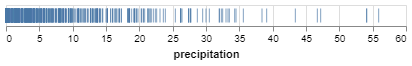

In [14]:
alt.Chart(df).mark_tick().encode(
        x='precipitation',
    )

It looks as though precipitation is skewed towards lower values; that is, when it rains in Seattle, it usually doesn’t rain very much. It is difficult to see patterns across continuous variables, and so to better see this, we can create a histogram of the precipitation data. For this we first discretize the precipitation values by adding a binning to x. Additionally, we set our encoding channel y with count. The result is a histogram of precipitation values:

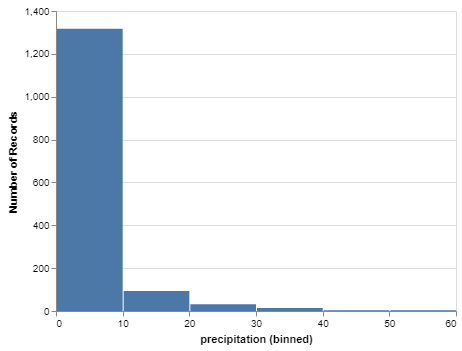

In [15]:
    alt.Chart(df).mark_bar().encode(
        alt.X('precipitation', bin=True),
        y='count()'
    )

Next, let’s look at how precipitation in Seattle changes throughout the year. Altair natively supports dates and discretization of dates when we set the type to temporal (shorthand T). For example, in the following plot, we compute the total precipitation for each month. To discretize the data into months, we can use a month binning (see :ref:`user-guide-timeunit-transform` for more information about this and other timeUnit binnings):

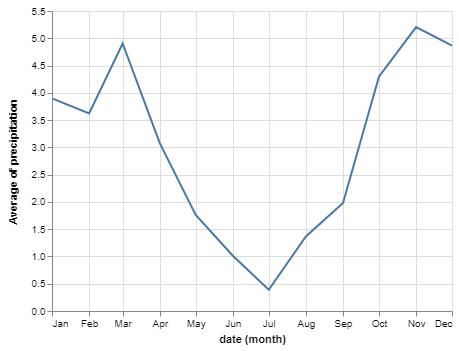

In [16]:
    alt.Chart(df).mark_line().encode(
        x='month(date):T',
        y='average(precipitation)'
    )


This chart shows that in Seattle the precipitation in the winter is, on average, much higher than summer (an unsurprising observation to those who live there!). By changing the mapping of encoding channels to data features, you can begin to explore the relationships within the data.

When looking at precipitation and temperature, we might want to aggregate by year and month (yearmonth) rather than just month. This allows us to see seasonal trends, with daily variation smoothed out. We might also wish to see the maximum and minimum temperature in each month:

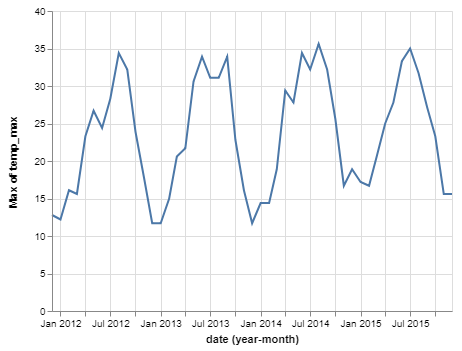

In [17]:
    alt.Chart(df).mark_line().encode(
        x='yearmonth(date):T',
        y='max(temp_max)',
    )


In this chart, it looks as though the maximum temperature is increasing from year to year over the course of this relatively short baseline. To look closer into this, let’s instead look at the mean of the maximum daily temperatures for each year:

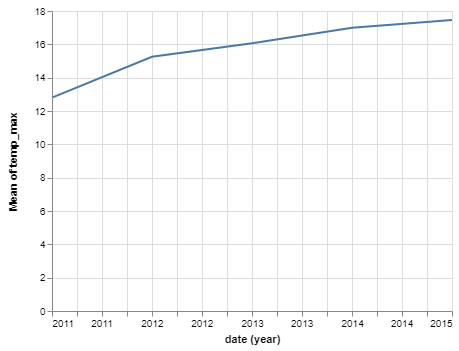

In [18]:
    alt.Chart(df).mark_line().encode(
        x='year(date):T',
        y='mean(temp_max)',
    )

This can be a little clearer if we use a bar plot and mark the year as an "ordinal" (ordered category) type. For aesthetic reasons, let's make the bar chart horizontal by assigning the ordinal value to the y-axis:

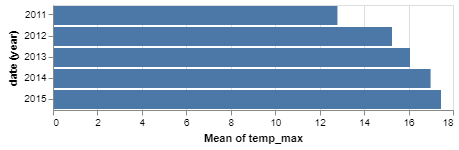

In [19]:
    alt.Chart(df).mark_bar().encode(
        x='mean(temp_max)',
        y='year(date):O'
    )


The chart indicates that the annual average of the daily high temperatures increased over the course of these four years, a fact that you can confirm for minimum daily temperatures as well.

You might also wonder how the daily temperature range changes throughout the year. For this, we have to add a computation to derive a new field, which can be done by adding a calculate transform:

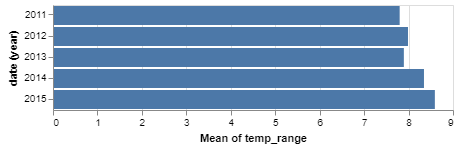

In [20]:
    alt.Chart(df).mark_bar().encode(
        x='mean(temp_range):Q',
        y='year(date):O'
    ).transform_calculate(
        temp_range="datum.temp_max - datum.temp_min"
    )

Note that this calculation doesn't actually do any data manipulation in Python, but rather encodes and stores the operations within the plot specification, where they will be calculated by the renderer.

Of course, the same calculation could be done by using Pandas manipulations to explicitly add a column to the dataframe; the disadvantage there is that the derived values would have to be stored in the plot specification rather than computed on-demand in the browser.

Next we will explore the weather field, which encodes a categorical variable describing the weather on a given day. We might wish to know how different kinds of weather (e.g. sunny days or rainy days) are distributed throughout the year. To answer this, we can discretize the date by month and then count the number of records on the y-Axis. We then break down the bars by the weather type by mapping this column to a color channel. When a bar chart has a field mapped to color, Altair will automatically stack the bars atop each other:

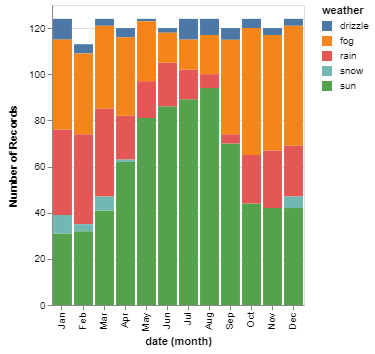

In [21]:
    alt.Chart(df).mark_bar().encode(
        x='month(date):N',
        y='count()',
        color='weather',
    )

The default color palette’s semantics might not match our expectation. For example, we probably do not expect “sun” (sunny) to be purple. We can tune the chart by providing a color scale range that maps the values from the weather field to meaningful colors, using standard hex color codes:

In [22]:
   scale = alt.Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
                     range=['#e7ba52', '#c7c7c7', '#aec7e8', '#1f77b4', '#9467bd'])

This scale can be passed to the color encoding to be applied to the plot style. In addition, we can customize the titles for the axis and legend to make the meaning of the plot more clear:

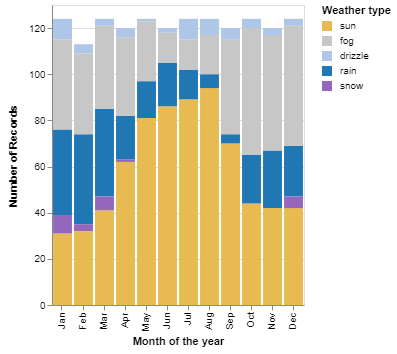

In [23]:
    alt.Chart(df).mark_bar().encode(
        x=alt.X('month(date):N', axis=alt.Axis(title='Month of the year')),
        y='count()',
        color=alt.Color('weather', legend=alt.Legend(title='Weather type'), scale=scale),
    )

Combining the above ideas lets us create any number of flexible visualizations of this dataset. For example, here is a plot that uses the customizations we have developed above to explore the relationship between weather, precipitation, maximum temperature, and temperature range, configured to use a larger canvas and to allow interactive panning and zooming with the mouse:

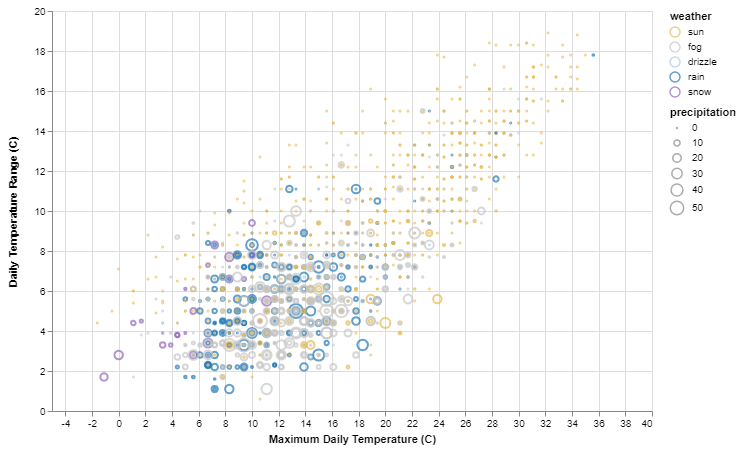

In [24]:
    alt.Chart(df).mark_point().encode(
        alt.X('temp_max', axis=alt.Axis(title='Maximum Daily Temperature (C)')),
        alt.Y('temp_range:Q', axis=alt.Axis(title='Daily Temperature Range (C)')),
        alt.Color('weather', scale=scale),
        alt.Size('precipitation', scale=alt.Scale(range=[1, 200]))
    ).transform_calculate(
        "temp_range", "datum.temp_max - datum.temp_min"
    ).properties(
        width=600,
        height=400
    ).interactive()

This gives us even more insight into the weather patterns in Seattle: rainy and foggy days tend to be cooler with a narrower range of temperatures, while warmer days tend to be dry and sunny, with a wider spread between low and high temperature.

You can take this even further using Altair's building blocks for multi-panel charts and interactions. For example, we might construct a histogram of days by weather type:

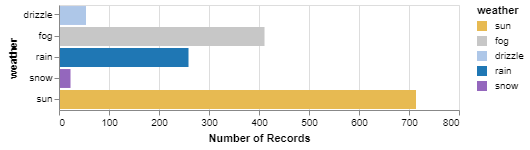

In [25]:
    alt.Chart(df).mark_bar().encode(
        x='count()',
        y='weather:N',
        color=alt.Color('weather:N', scale=scale),
    )

And now we can vertically concatenate this histogram to the points plot above, and add a brush selection tool such that the histogram reflects the content of the selection (for more information on selections, see :ref:`user-guide-selections`):

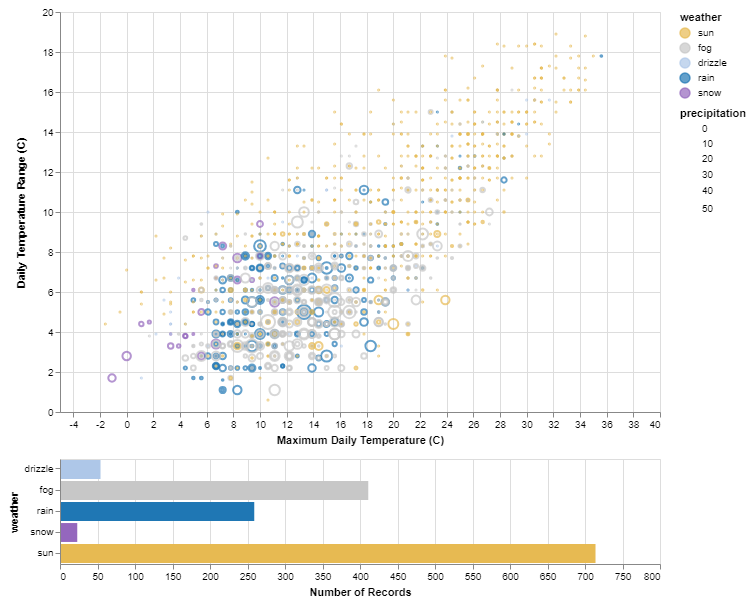

In [26]:
    brush = alt.selection(type='interval')

    points = alt.Chart().mark_point().encode(
        alt.X('temp_max:Q', axis=alt.Axis(title='Maximum Daily Temperature (C)')),
        alt.Y('temp_range:Q', axis=alt.Axis(title='Daily Temperature Range (C)')),
        color=alt.condition(brush, 'weather:N', alt.value('lightgray'), scale=scale),
        size=alt.Size('precipitation:Q', scale=alt.Scale(range=[1, 200]))
    ).transform_calculate(
        "temp_range", "datum.temp_max - datum.temp_min"
    ).properties(
        width=600,
        height=400
    ).add_selection(
        brush
    )

    bars = alt.Chart().mark_bar().encode(
        x='count()',
        y='weather:N',
        color=alt.Color('weather:N', scale=scale),
    ).transform_calculate(
        "temp_range", "datum.temp_max - datum.temp_min"
    ).transform_filter(
        brush
    ).properties(
        width=600
    )

    alt.vconcat(points, bars, data=df)

In [ ]:
This chart, containing concatenations, data transformations, selections, and customized axes labels and data scales, shows the power of the grammar behind Altair: you can create a complex chart from a small number of building blocks.

This is the end of this tutorial where you have seen various ways to bin and aggregate data, derive new fields, and customize your charts. You can find more visualizations in the :ref:`example-gallery`. If you want to further customize your charts, you can refer to Altair's :ref:`API`.